In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
import seaborn as sns
import tensorflow as tf
import copy
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import shap

C:\Users\aneyk\anaconda3\envs\tf_cpu\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
cols = ["Age", "Gender", "Hemoglobin", "Platelet_count", "White_Blood_Cells", "Red_Blood_Cells", "MCV", "MCH", "MCHC"]
df = pd.read_csv("../data/blood_count_dataset.csv")
df.columns = cols

In [3]:
df.head()

,Age,Gender,Hemoglobin,Platelet_count,White_Blood_Cells,Red_Blood_Cells,MCV,MCH,MCHC
0,68,Female,10.4,180000,5700,3.7,77,25,32
1,25,Male,13.8,320000,7500,5.4,92,30,32
2,57,Male,13.5,370000,8500,5.1,90,29,32
3,28,Female,12.7,290000,7800,4.8,86,29,33
4,38,Male,14.9,380000,8700,5.7,95,31,33


In [4]:
print(df.isnull().sum())

Age                  0
Gender               0
Hemoglobin           0
Platelet_count       0
White_Blood_Cells    0
Red_Blood_Cells      0
MCV                  0
MCH                  0
MCHC                 0
dtype: int64


In [5]:
df['Gender'].unique()

array(['Female', 'Male'], dtype=object)

In [6]:
df['Gender'] = (df["Gender"] == "Male").astype(int)

In [7]:
df.dropna()

,Age,Gender,Hemoglobin,Platelet_count,White_Blood_Cells,Red_Blood_Cells,MCV,MCH,MCHC
0,68,0,10.4,180000,5700,3.7,77,25,32
1,25,1,13.8,320000,7500,5.4,92,30,32
2,57,1,13.5,370000,8500,5.1,90,29,32
3,28,0,12.7,290000,7800,4.8,86,29,33
4,38,1,14.9,380000,8700,5.7,95,31,33
...,...,...,...,...,...,...,...,...,...
412,40,1,15.2,400000,9200,5.8,96,32,33
413,52,1,13.5,350000,8000,5.3,92,30,32
414,30,0,11.8,250000,7000,4.2,84,27,32
415,60,0,11.0,200000,6000,4.0,80,26,32


In [11]:
dfr = pd.read_csv("../data/Blood_Cell_Count_Red.csv")
dfw = pd.read_csv("../data/Blood_Cell_Count_White.csv")

In [12]:
dfr.head()

,Red_Blood_Cells,Gender,Hemoglobin,Platelet_count,Age,MCV,MCH,MCHC
0,3.7,0,10.4,180000,68,77,25,32
1,5.4,0,13.8,320000,25,92,30,32
2,5.1,0,13.5,370000,57,90,29,32
3,4.8,0,12.7,290000,28,86,29,33
4,5.7,0,14.9,380000,38,95,31,33


In [13]:
dfw.head()

,White_Blood_Cells,Gender,Hemoglobin,Platelet_count,Age,MCV,MCH,MCHC
0,5700,0,10.4,180000,68,77,25,32
1,7500,0,13.8,320000,25,92,30,32
2,8500,0,13.5,370000,57,90,29,32
3,7800,0,12.7,290000,28,86,29,33
4,8700,0,14.9,380000,38,95,31,33


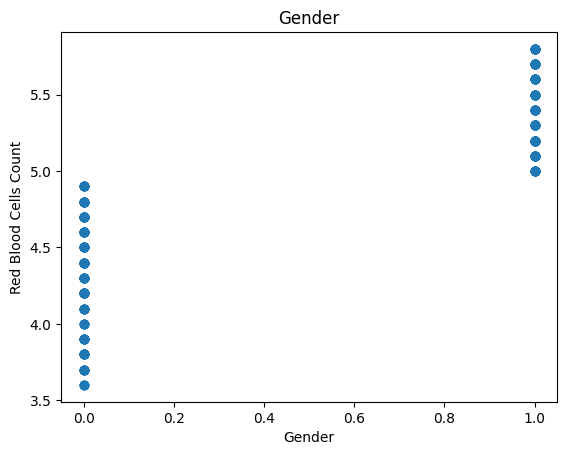

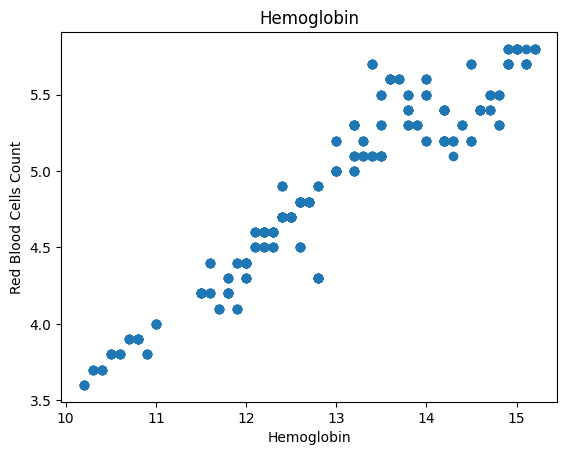

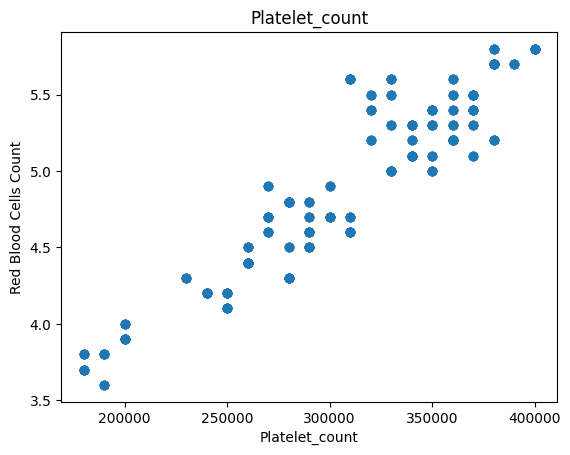

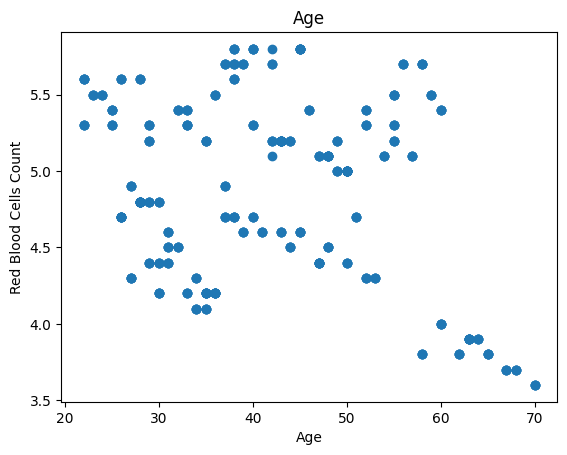

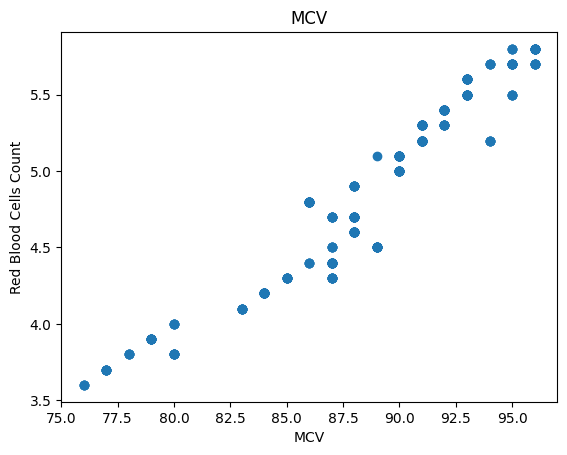

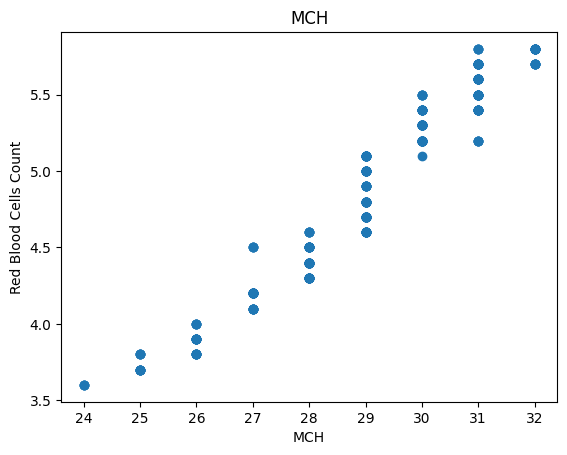

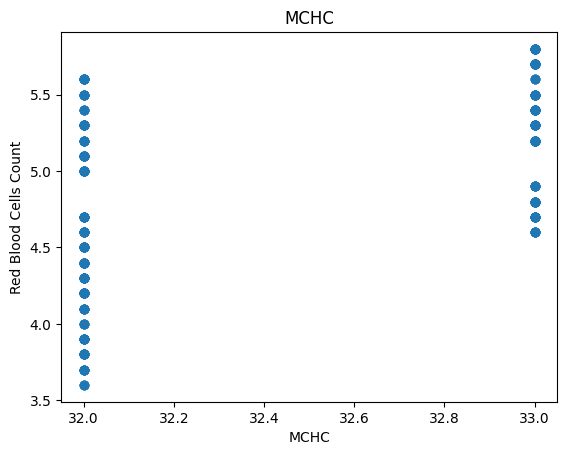

In [14]:
for label in dfr.columns[1:]: # lets see if we see any correlations
    plt.scatter(df[label], dfr["Red_Blood_Cells"]) 
    plt.title(label)
    plt.ylabel("Red Blood Cells Count")
    plt.xlabel(label)
    plt.show()

In [15]:
dfr = dfr.drop(["Gender", "Platelet_count", "MCHC"],axis=1)

In [16]:
dfr.head()

,Red_Blood_Cells,Hemoglobin,Age,MCV,MCH
0,3.7,10.4,68,77,25
1,5.4,13.8,25,92,30
2,5.1,13.5,57,90,29
3,4.8,12.7,28,86,29
4,5.7,14.9,38,95,31


In [17]:
train, val, test = np.split(dfr.sample(frac=1), [int(0.6*len(dfr)), int(0.8*len(dfr))]) # train, valid, test split; 60/20/20 split

C:\Users\aneyk\anaconda3\envs\tf_cpu\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [18]:
def get_xy(dataframe, y_label, x_labels=None):
  dataframe = copy.deepcopy(dataframe)
  
  if x_labels is None:
    X = dataframe[[c for c in dataframe.columns if c!=y_label]].values
    
  else:
    if len(x_labels) == 1:
      X = dataframe[x_labels[0]].values.reshape(-1, 1)
    else:
      X = dataframe[x_labels].values

  y = dataframe[y_label].values.reshape(-1, 1)
  data = np.hstack((X, y))

  return data, X, y

In [19]:
_, X_train_all, y_train_all = get_xy(train, "Red_Blood_Cells", x_labels= dfr.columns[1:])
_, X_val_all, y_val_all = get_xy(val, "Red_Blood_Cells", x_labels= dfr.columns[1:])
_, X_test_all, y_test_all = get_xy(test, "Red_Blood_Cells", x_labels= dfr.columns[1:])

In [20]:
lr = LinearRegression()
lr = lr.fit(X_train_all, y_train_all)

In [21]:
lr.score(X_test_all, y_test_all)

0.9467984201320016

In [22]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('MSE')
  plt.legend()
  plt.grid(True)
  plt.show()

In [23]:
all_normalizer = tf.keras.layers.Normalization(input_shape=(4,), axis=-1)
all_normalizer.adapt(X_train_all)

C:\Users\aneyk\anaconda3\envs\tf_cpu\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [24]:
nn_model = tf.keras.Sequential([
    all_normalizer,
    tf.keras.layers.Dense(64, activation='tanh'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])
nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

In [25]:
history = nn_model.fit(
    X_train_all, y_train_all,
    validation_data=(X_val_all, y_val_all),
    verbose=0, epochs=100
)

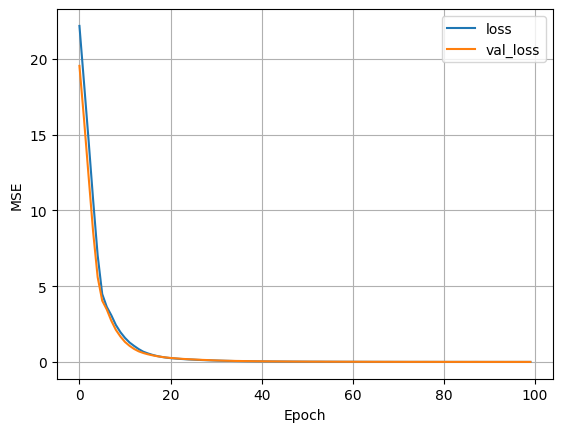

In [26]:
plot_loss(history)

In [27]:
y_pred_lr = lr.predict(X_test_all)
y_pred_nn = nn_model.predict(X_test_all)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


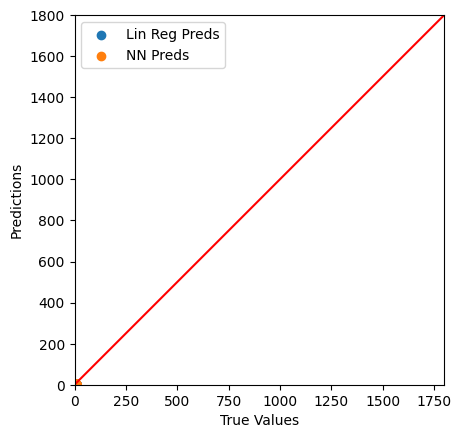

In [28]:
ax = plt.axes(aspect="equal")
plt.scatter(y_test_all, y_pred_lr, label="Lin Reg Preds")
plt.scatter(y_test_all, y_pred_nn, label="NN Preds")
plt.xlabel("True Values")
plt.ylabel("Predictions")
lims = [0, 1800]
plt.xlim(lims)
plt.ylim(lims)
plt.legend()
_ = plt.plot(lims, lims, c="red")

In [29]:
svr_model = SVR()

In [30]:
svr_model.fit(X_train_all, y_train_all)

C:\Users\aneyk\anaconda3\envs\tf_cpu\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR()

In [31]:
svr_model.score(X_test_all, y_test_all)

0.944932227775919

In [32]:
clf = DecisionTreeRegressor()

In [33]:
clf.fit(X_train_all, y_train_all)

DecisionTreeRegressor()

In [34]:
clf.score(X_test_all, y_test_all)

0.9985095521736584

In [35]:
y_val_pred = clf.predict(X_val_all)
print("Validation R²:", r2_score(y_val_all, y_val_pred))

Validation R²: 0.9998085945210988


In [36]:
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train_all, y_train_all)
print("Test R²:", rf.score(X_test_all, y_test_all))

Test R²: 0.9989765798053086


C:\Users\aneyk\anaconda3\envs\tf_cpu\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [37]:
y_val_pred = rf.predict(X_val_all)
print("Validation R²:", r2_score(y_val_all, y_val_pred))

Validation R²: 0.9994092313764318


In [38]:
final_features = ['Red_Blood_Cells', 'Hemoglobin', 'Age', 'MCV', 'MCH']
explainer = shap.Explainer(rf, X_train_all, feature_names = final_features)
shap_values = explainer(X_test_all)

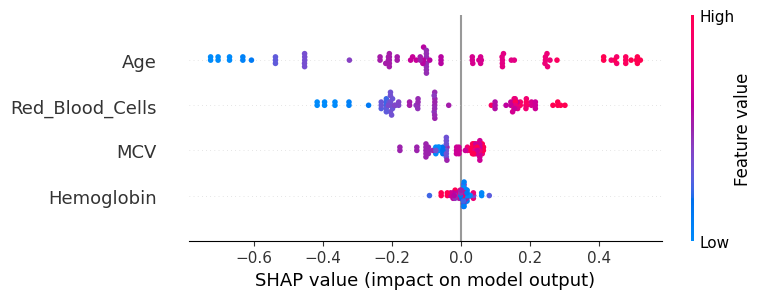

In [39]:
shap.summary_plot(shap_values, X_test_all, feature_names=final_features)